Modelo de Predicción de Ventas diario para DATACHEF
*Suavizado Exponencial*

#Configuración de ambiente

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Inicialización


In [57]:
!pip install packaging==21.3
!pip install pycaret
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [58]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pycaret
from pycaret.time_series import *
from sktime.forecasting.model_selection import SlidingWindowSplitter

#PYCARET-2 DIARIO

In [59]:
# check installed version
pycaret.__version__

'3.3.0'

##Preparando dataset

In [5]:
df_ventasTotal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto No Country/base de datos/order_combined.csv')
df_ventas = df_ventasTotal[['date_open', 'total']].copy()
df_ventas['date_open'] = pd.to_datetime(df_ventas['date_open'])
# Paso 1: Preprocesamiento de datos
df=df_ventas.copy()
# Renombrar las columnas 'date_open' y 'total'
df.rename(columns={'total': 'ventas', 'date_open': 'date'}, inplace=True)
# Establecer la columna 'date_open' como el índice del DataFrame
df.set_index('date', inplace=True)
# Convertir el índice de formato de fecha y hora a solo formato de fecha
df.index = df.index.date

# Convertir el índice a tipo DatetimeIndex
df.index = pd.to_datetime(df.index)

# Agrupar el DataFrame por día y sumar las ventas
df_diario = df.groupby(pd.Grouper(freq='D')).sum()

# Mostrar el DataFrame agrupado
df=df_diario.copy()

df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913 entries, 2021-08-13 to 2024-02-11
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ventas  913 non-null    float64
dtypes: float64(1)
memory usage: 14.3 KB


In [6]:
df.tail()

,ventas
2024-02-07,1272438.0
2024-02-08,1368061.0
2024-02-09,2636401.0
2024-02-10,1888322.0
2024-02-11,1253848.0


In [7]:
df.describe()

,ventas
count,9.130000e+02
mean,1.210350e+06
std,6.381966e+05
min,0.000000e+00
25%,7.128200e+05
50%,1.106693e+06
75%,1.645000e+06
max,3.380780e+06


###Visualizando dataframe original

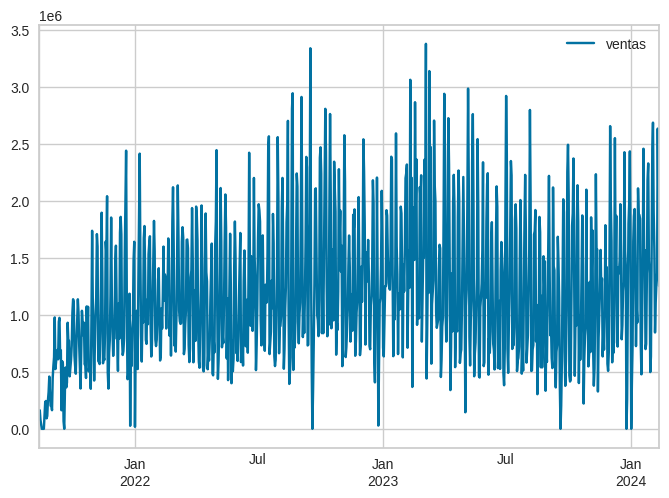

In [8]:
df.plot()
plt.show()

###Time series Cross validation with PyCaret

En este ejemplo se muestra como funciona la validación cruzada usndo la estrategia de partición sliding window splitter

In [9]:
import numpy as np
from sktime.forecasting.model_selection import SlidingWindowSplitter
ts = np.arange(10)
splitter = SlidingWindowSplitter(fh=np.arange(1,3), window_length=3, step_length=1)
list(splitter.split(ts))

[(array([0, 1, 2]), array([3, 4])),
 (array([1, 2, 3]), array([4, 5])),
 (array([2, 3, 4]), array([5, 6])),
 (array([3, 4, 5]), array([6, 7])),
 (array([4, 5, 6]), array([7, 8])),
 (array([5, 6, 7]), array([8, 9]))]

##Configuración del modelo predictivo

exp = TSForecastingExperiment(): Crea una instancia de la clase TSForecastingExperiment.

exp.setup(data=df, target='ventas', ...): Configura el experimento con los siguientes parámetros:
data: Indica el DataFrame que contiene los datos de la serie temporal (en este caso, "df").

target: Especifica la variable objetivo que se quiere predecir (en este caso, "ventas").

coverage: Establece el porcentaje de datos que se utilizará para entrenar el modelo (en este caso, 0.95, lo que significa que se utilizará el 95% de los datos para el entrenamiento).

fold_strategy: Define la estrategia de partición de datos para la validación cruzada. En este caso, se utiliza un validador de ventana deslizante (SlidingWindowSplitter).

fh: Un array de horizontes de pronóstico (en este caso, del 1 al 19, indicando que se harán predicciones a 1, 2, ..., 19 pasos en el futuro).

window_length: Tamaño de la ventana de datos que se usará para entrenar el modelo (en este caso, 90 días).

step_length: Paso entre ventanas para la validación cruzada deslizante (en este caso, 90 días).

In [10]:
exp = TSForecastingExperiment()
exp.setup(data = df, target='ventas' , session_id= 8549, coverage=0.95, fold_strategy=SlidingWindowSplitter(fh=np.arange(1,30),  window_length=90, step_length=90)) # utilizando los datos de los últimos 3 meses para hacer predicciones para el próximo 30 dias y avanzando 3 MESES hacia adelante."

,Description,Value
0,session_id,8549
1,Target,ventas
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(913, 1)"
5,Transformed data shape,"(913, 1)"
6,Transformed train set shape,"(884, 1)"
7,Transformed test set shape,"(29, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,SlidingWindowSplitter


###Graficar Set de entrenamiento y validación cruzada

In [11]:
exp.plot_model(plot='train_test_split')

In [12]:
exp.plot_model(plot='cv')

###Comparar metricas de modelos

In [13]:
exp.compare_models(sort='rmse')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,0.8367,0.7802,273046.6106,341247.1941,0.2641,0.2504,0.6116,0.0989
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8683,0.8156,282748.4470,357578.1850,0.2646,0.2424,0.5743,0.9978
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.8707,0.8194,282263.6217,357942.2441,0.2642,0.2429,0.5757,0.8478
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8717,0.8187,283542.3640,358370.3670,0.2664,0.2436,0.5733,0.9733
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8717,0.8187,283542.3640,358370.3670,0.2664,0.2436,0.5733,1.0222
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.8717,0.8187,283542.3640,358370.3670,0.2664,0.2436,0.5733,0.8044
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.8717,0.8187,283542.3640,358370.3670,0.2664,0.2436,0.5733,1.1133
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8717,0.8187,283542.3640,358370.3670,0.2664,0.2436,0.5733,0.9878
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8696,0.8201,282533.4636,358924.1617,0.2645,0.2431,0.5738,1.0878
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8957,0.8394,295174.4061,369580.6876,0.2754,0.2538,0.5404,1.2067


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

ExponentialSmoothing(seasonal='add', sp=7, trend='add')

##Comparando métricas sólo de algunos modelos de interés particular

In [14]:
my_models = ['omp_cds_dt','et_cds_dt', 'br_cds_dt','lasso_cds_dt', 'exp_smooth','ets', 'arima','auto_arima', 'rf_cds_dt', 'knn_cds_dt', 'xgboost_cds_dt', 'lightgbm_cds_dt', 'huber_cds_dt']
exp.compare_models(include=my_models, sort='rmse')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,0.8367,0.7802,273046.6106,341247.1941,0.2641,0.2504,0.6116,0.1211
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8683,0.8156,282748.4470,357578.1850,0.2646,0.2424,0.5743,1.2556
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.8707,0.8194,282263.6217,357942.2441,0.2642,0.2429,0.5757,2.5767
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8717,0.8187,283542.3640,358370.3670,0.2664,0.2436,0.5733,0.9733
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8696,0.8201,282533.4636,358924.1617,0.2645,0.2431,0.5738,1.1056
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.8799,0.8491,291156.7164,374085.0455,0.2525,0.2477,0.5303,1.8844
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.9099,0.8553,297149.0456,375054.5936,0.2779,0.2541,0.5217,1.6311
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.9114,0.8646,297822.1960,378987.4910,0.2775,0.2527,0.5143,1.7878
ets,ETS,0.9724,0.8774,321871.2806,386804.3768,0.3182,0.3083,0.4867,0.1867
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9450,0.8915,307078.2933,389559.2622,0.2804,0.2669,0.4917,1.6200


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

ExponentialSmoothing(seasonal='add', sp=7, trend='add')

###Creación de varis modelos de manera individual

In [ ]:
br_cds_dt = exp.create_model('br_cds_dt')

In [ ]:
tuned_br_cds_dt = exp.tune_model(br_cds_dt)

In [ ]:
arima = exp.create_model('arima')

In [ ]:
tuned_arima = exp.tune_model(arima)

In [ ]:
xgboost = exp.create_model('xgboost_cds_dt')

In [ ]:
tuned_xgboost = exp.tune_model(xgboost)

In [ ]:
knn = exp.create_model('knn_cds_dt')

In [ ]:
tuned_knn = exp.tune_model(knn)

##Crear Modelo con mejor desempeño segun las métricas obtenidas en la comparación. "Exponential Smoothing"(Suavizado exponencial)

In [15]:
exp_smooth = exp.create_model('exp_smooth')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2021-11-10,1.0739,0.9332,240497.7595,289336.1900,0.3019,0.2473,0.5999
1,2022-02-08,0.6906,0.5296,220209.5607,266001.1930,0.1948,0.1911,0.5458
2,2022-05-09,0.6285,0.5882,166036.5908,200566.0060,0.1879,0.1799,0.8205
3,2022-08-07,0.9625,0.9326,329714.5523,427986.6918,0.3479,0.2735,0.6971
4,2022-11-05,0.6395,0.6049,286019.2531,338236.7421,0.2421,0.2172,0.6032
5,2023-02-03,1.0461,0.9407,352144.8827,444375.4539,0.2449,0.2289,0.5308
6,2023-05-04,0.6142,0.6732,240917.3124,334905.2943,0.1986,0.1769,0.7967
7,2023-08-02,0.8747,0.8560,269268.9567,348515.7247,0.3009,0.2638,0.6592
8,2023-10-31,1.0005,0.9635,352610.6270,421301.4507,0.3582,0.4746,0.2507
Mean,NaT,0.8367,0.7802,273046.6106,341247.1941,0.2641,0.2504,0.6116


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

###Tuned Models. Mejorar los hiperparámetros de manera automática con Pycaret

Esta función ajusta los hiperparámetros de un estimador dado. La salida de esta función es una score grid con las puntuaciones de CV por pliegue del mejor modelo seleccionado en función del parámetro optimizado.

In [16]:
tuned_exp_smooth= exp.tune_model(exp_smooth, optimize='MAE', n_iter=15)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2021-11-10,0.7692,0.8335,172266.6174,258444.6729,0.1614,0.1639,0.6808
1,2022-02-08,0.8080,0.6430,257631.2968,322942.3187,0.2136,0.2461,0.3305
2,2022-05-09,0.6852,0.6326,181006.4570,215705.9574,0.2158,0.1946,0.7923
3,2022-08-07,0.9482,0.9562,324818.3349,438813.3430,0.3122,0.2629,0.6816
4,2022-11-05,0.6530,0.6211,292079.3274,347277.0302,0.2479,0.2194,0.5818
5,2023-02-03,1.0500,1.0141,353441.8968,479058.2456,0.2188,0.2254,0.4548
6,2023-05-04,0.6402,0.6824,251095.3932,339468.7543,0.1890,0.1793,0.7912
7,2023-08-02,0.8808,0.8572,271154.6388,349028.8961,0.3056,0.2650,0.6581
8,2023-10-31,0.7745,0.7690,272959.5825,336249.3681,0.2703,0.2959,0.5227
Mean,NaT,0.8010,0.7788,264050.3939,342998.7318,0.2372,0.2281,0.6104


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 9 folds for each of 4 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.3s finished


El ajuste de hiperparámetros mejoró el MAE , MASE y RMSSE con una ligera variación en R2. Tomaremos estos hiperparámteros mejorados para continuar con el modelo

In [17]:
tuned_exp_smooth

ExponentialSmoothing(seasonal='add', sp=7, use_boxcox=False)

##Análisis de los resultados:
El promedio de ventas diaria del restaurante es de 1210350 pesos chileno, con una desviación de 638196 pesos,lo que indica alta variabilidad en  las ventas, con un minimo por dia de 0 pesos y un máximo de 3380780 pesos. EL 75% de las ventas estan por debajo de 1645000 pesos y el valor medio de las ventas diarias es de 1106693 pesos chileos.

MASE: El valor de MASE (0.8010) indica que el modelo es mejor que la media simple, pero aún hay espacio para mejorar la precisión.

El RMSSE de 0.7788 y el MAE de 264.050 unidades indican que el error del modelo es relativamente alto.

El RMSE de 342.998 unidades indica que la raíz cuadrada del error cuadrático medio es considerable.

El MAPE de 0.2372 y el SMAPE de 0.2281 indican que el error porcentual absoluto promedio es de alrededor del 23%.

El R^2 de 0.6104 indica que el modelo explica alrededor del 61% de la variabilidad de la serie temporal. Esto significa que hay un 39% de la variabilidad que el modelo no explica, lo que se traduce en un margen de error considerable.

##Visualización de caracteristicas del modelo


In [18]:
exp.plot_model(estimator=tuned_exp_smooth, plot="diagnostics")
#Estás especificando que quieres generar un gráfico para el modelo de suavizado exponencial que ha sido ajustado y guardado en la variable tuned_exp_smooth.
#plot="diagnostics": Estás especificando que quieres generar un gráfico de diagnóstico. Los gráficos de diagnóstico son útiles para entender cómo se comporta tu modelo, identificar posibles problemas y validar los supuestos del modelo.

In [19]:
exp.plot_model(tuned_exp_smooth, plot='insample')

##Visualización del modelo predictivo con datos futuros

Se comparan los valores reales con los pronósticos generados utilizando datos que no formaban parte del conjunto de datos utilizado para entrenar el modelo o generar los pronósticos. Este tipo de análisis es importante para evaluar la capacidad predictiva de un modelo en situaciones nuevas o desconocidas, ya que muestra cómo se desempeña el modelo cuando se le presenta información que no ha visto antes. En este caso para una línea futura de 90 días.

In [20]:
exp.plot_model(tuned_exp_smooth, plot='forecast', data_kwargs={'fh':90})

##Predict Model Pycaret diaro

predict_model(): Es una función de PyCaret que se utiliza para hacer predicciones con un modelo entrenado. Toma como entrada un modelo entrenado y un conjunto de datos (opcional), y devuelve las predicciones del modelo para ese conjunto de datos. Si no se proporciona un conjunto de datos, la función hará predicciones para el conjunto de datos de prueba que se separó durante la configuración del experimento.

In [21]:
holdout_pred = exp.predict_model(tuned_exp_smooth)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.8372,0.7930,277066.9789,352844.9341,0.1968,0.2035,0.6927


##Precisión del modelo realizando una predicción para un conjunto de prueba de 30 días:

El MASE de 0.8372 indica que el modelo es un poco mejor que la media simple, pero aún hay espacio para mejorar la precisión.
El RMSSE de 0.7930 y el MAE de 277.067 unidades indican que el error del modelo es relativamente alto.
El RMSE de 352.845 unidades indica que la raíz cuadrada del error cuadrático medio es considerable.
El MAPE de 0.1968 y el SMAPE de 0.2035 indican que el error porcentual absoluto promedio es de alrededor del 19.68%. El R2 explica el 69,3% de la variabilidad y un error de 30,7% lo cual es considerable.

In [22]:
holdout_pred.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 29 entries, 2024-01-14 to 2024-02-11
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_pred  29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes


###Finalizar modelo

final_model = exp.finalize_model(tuned_exp_smooth): Después de ajustar los hiperparámetros del modelo de series temporales (en este caso, un modelo exponencial suavizado), se finaliza el modelo seleccionado. La función finalize_model ajusta el modelo al conjunto de datos completo y lo prepara para su uso en predicciones futuras.

In [26]:
final_model = exp.finalize_model(tuned_exp_smooth)

In [24]:
exp.plot_model(final_model, plot='forecast', data_kwargs={'fh':90})

##Predicciones

predicciones = exp.predict_model(final_model, fh=90): Aquí estás usando el modelo finalizado para hacer predicciones sobre datos no vistos. Específicamente, estás utilizando la función predict_model para hacer predicciones para un horizonte de pronóstico de 90 periodos (que puede ser días, semanas, meses, etc., dependiendo de tu serie temporal), para nuestro caso será en días para obtener la venta diaria del restaurante.

In [27]:
predicciones = exp.predict_model(final_model, fh=120)
predicciones


,y_pred
2024-02-12,7.155402e+05
2024-02-13,8.549140e+05
2024-02-14,1.245890e+06
2024-02-15,1.796292e+06
2024-02-16,2.381981e+06
...,...
2024-05-07,8.549140e+05
2024-05-08,1.245890e+06
2024-05-09,1.796292e+06
2024-05-10,2.381981e+06


##Consulta de venta futura por día requerido

In [53]:
fecha_seleccionada = '2024-05-07'
prediccion = predicciones.loc[fecha_seleccionada]

# Acceder al valor numérico dentro de la serie y luego imprimirlo
print(f'La predicción para el {fecha_seleccionada} es de {prediccion.values[0]:.2f} pesos chilenos')


La predicción para el 2024-05-07 es de 854913.99 pesos


##Conclusiones del modelo

Conclusiones:

El modelo de pronóstico de ventas puede ser una herramienta útil para la gestión del restaurante, pero es importante utilizarlo con cautela y tener en cuenta sus limitaciones.

Las métricas del modelo indican que existe una probabilidad de alrededor del 61% de que las predicciones del modelo sean precisas. Sin embargo, también hay una probabilidad de alrededor del 39% de que las predicciones del modelo tengan un error considerable.

Es importante monitorizar el rendimiento del modelo a lo largo del tiempo y realizar ajustes con la información real de ventas a medida que transcurra el tiempo.


Recomendaciones:
De acuerdo a los días con mayor pronóstico de ventas , puede aplicar distitas estrategias:

Planificación de la producción: Estimar la cantidad de comida que se debe preparar cada día, lo que puede ayudar a reducir el desperdicio y optimizar los costos.

Gestión de personal: El modelo puede usarse para estimar la cantidad de personal que se necesita cada día, lo que puede ayudar a optimizar la eficiencia del servicio.

Marketing y promociones: El modelo puede usarse para identificar los mejores momentos para realizar promociones y campañas de marketing.

De esta manera puede utilizar el modelo como una herramienta para la toma de decisiones, pero no como la única fuente de información. Es importante combinar las predicciones del modelo con la experiencia del personal y otros datos relevantes para tomar mejores decisiones.


#Modelo para Streamlit

In [60]:
import streamlit as st
import pandas as pd

# Aquí supongamos que tienes tu DataFrame de predicciones predicciones
# predicciones = ...

# Definir la interfaz de usuario con Streamlit
st.title('Consulta de Predicciones')

# Agregar un control deslizante para seleccionar el horizonte de pronóstico (fh)
fh = st.slider('Seleccione el horizonte de pronóstico (fh)', min_value=1, max_value=120, value=30)

# Agregar un selector de fecha para consultar la predicción
fecha_seleccionada = st.date_input('Seleccione una fecha para consultar la predicción')

# Verificar si la fecha seleccionada está en el DataFrame de predicciones
if fecha_seleccionada in predicciones.index:
    prediccion = predicciones.loc[fecha_seleccionada]
    st.write(f'La predicción para el {fecha_seleccionada} es de {prediccion.values[0]:.2f} pesos')
else:
    st.write('No hay predicción disponible para la fecha seleccionada')

2024-03-14 12:36:55.181 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-03-14 12:36:55.184 Session state does not function when running a script without `streamlit run`


Se importa Streamlit como st y Pandas como pd.
Se define la interfaz de usuario, incluyendo un título, un control deslizante para seleccionar el horizonte de pronóstico (fh) y un selector de fecha para elegir la fecha de consulta.
Se verifica si la fecha seleccionada está en el DataFrame de predicciones. Si está presente, se muestra la predicción correspondiente con un mensaje similar al que proporcionaste.